# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Feature extraction](#Feature-extraction)
  * [One-class LDA on FRILL embeddings](#One-class-LDA-on-FRILL-embeddings)
  * [Spherical coordinates from optionally scaled data](#Spherical-coordinates-from-optionally-scaled-data)
* [Concatenate features](#Concatenate-features)

# Introduction

To speed development, 5-fold train-test splits were preprocessed and prepared as separate .feather files, which included the extraction of several new features. This notebook introduces one-class LDA components based on the FRILL embeddings. In addition, for each of five possible intermediate scaling procedures, this notebook introduces additional features by converting certain pairs/triplets of features into polar/spherical coordinates (respectively) plus two LDA components.

I thought about PCA or rbf kPCA too, but it didn't work that well (or that fast) on the FRILL embeddings IIRC. LDA and OC-LDA as well as OC LOF or SVM scores could ostensibly be computed on larger and larger feature sets ad infinitum.

decide on poly cut-off... 2 even 2 odd is fine: 2 3 4 5, and 6?

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Dict, List, Tuple, Union

# feature engineering
from numpy import arctan2, hypot, sqrt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# import warnings

# warnings.filterwarnings("ignore")
# del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.25 s


In [4]:
# Location of CV .feather files
CV_FEATHERS_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 105 ms


# Setup

Constants

In [5]:
VALENCES = ("neg", "neu", "pos")
KERNELS = ("rbf", "sgdlinear", "sigmoid")
POLYS = (2, 3, 4, 5, 6)
NEIGHBORS = (10, 20, 30)
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}
SCALERS = {
    None: lambda: None,
    "StSc": lambda: StandardScaler(),
    "YJ-StSc": lambda: PowerTransformer(
        method="yeo-johnson", standardize=True
    ),  # default
    "QT-unif": lambda: QuantileTransformer(
        output_distribution="uniform", random_state=SEED
    ),
    "QT-norm": lambda: QuantileTransformer(
        output_distribution="normal", random_state=SEED
    ),
}
DOUBLES = (
    ["LDA1", "LDA2"],
    *[[f"{kernel}_LDA1", f"{kernel}_LDA2"] for kernel in KERNELS],
    *[[f"poly{deg}_LDA1", f"poly{deg}_LDA2"] for deg in POLYS],
)
TRIPLES = (
    *[
        [f"LDA-LOF_{valence}_{n_neighbors}" for valence in VALENCES]
        for n_neighbors in NEIGHBORS
    ],
    *[
        [f"LOF_{valence}_{n_neighbors}" for valence in VALENCES]
        for n_neighbors in NEIGHBORS
    ],
    *[[f"ocsvm_{kernel}_{valence}" for valence in VALENCES] for kernel in KERNELS],
    *[[f"ocsvm_poly{deg}_{valence}" for valence in VALENCES] for deg in POLYS],
    *[[f"LDA_{kernel}_{valence}" for valence in VALENCES] for kernel in KERNELS],
    *[[f"LDA_poly{deg}_{valence}" for valence in VALENCES] for deg in POLYS],
    [f"OC_LDA_{valence}" for valence in VALENCES],
)

_ = gc_collect()

time: 110 ms


Read data

In [6]:
def read_data(train_or_test: str, fold_num: int = 0) -> Tuple[pd.DataFrame, pd.Series]:
    """Read labels and FRILL-derived features"""
    read_feather = lambda filename: pd.read_feather(
        f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
    )
    x_prefix = f"X_{train_or_test}"
    _ = [
        read_feather(f"{x_prefix}_LDA"),
        read_feather(f"{x_prefix}_LDA-LOF_scores"),
        read_feather(f"{x_prefix}_LOF_scores"),
        read_feather(f"{x_prefix}_OC_LDA"),
        *[
            read_feather(f"{x_prefix}_OC_{kernel}")
            for kernel in ("rbf", "sgdlinear", "sigmoid")
        ],
        *[read_feather(f"{x_prefix}_OC_poly{deg}") for deg in POLYS],
    ]
    for i in range(len(_)):
        _[i] = _[i].reset_index(drop=True)
        assert not _[i].isnull().values.any()
        assert len(_[i]) == len(_[0])
    _ = pd.concat(
        _,
        axis="columns",
    ).astype(np.float64)
    assert not _.isnull().values.any()
    return (
        _,
        read_feather(f"y_{train_or_test}_untransformed").iloc[:, 0],
    )


def read_FRILL(train_or_test: str, fold_num: int = 0) -> Tuple[pd.DataFrame, pd.Series]:
    """Read labels and FRILL features"""
    read_feather = lambda filename: pd.read_feather(
        f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
    )
    return (
        read_feather(f"X_{train_or_test}_untransformed").astype(np.float64),
        read_feather(f"y_{train_or_test}_untransformed").iloc[:, 0],
    )


_ = gc_collect()

time: 118 ms


Plotting functions

In [7]:
def plot2d(
    col1: str,
    col2: str,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    suptitle: str = "",
) -> None:
    """Plot 2D scatterplot"""
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_params = {
        "x": col1,
        "y": col2,
        "palette": "viridis",
        "hue_order": [0, 1, 2],
        "alpha": 0.25,
        "legend": False,
        "linewidth": 0,
        "marker": ".",
        "s": 50,
    }
    sns.scatterplot(
        hue=y_train,
        data=X_train,
        ax=ax[0],
        **plot_params,
    )
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    sns.scatterplot(
        hue=y_test,
        data=X_test,
        ax=ax[1],
        **plot_params,
    )
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    plt.setp(ax[1], xlim=ax[0].get_xlim(), ylim=ax[0].get_ylim())
    plt.suptitle(f"{suptitle}: {col1} and {col2}")
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.show()


def plot3d(
    col1: str,
    col2: str,
    col3: str,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    suptitle: str = "",
) -> None:
    """Plot 3d scatterplot"""
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(
        X_train[col1],
        X_train[col2],
        X_train[col3],
        alpha=0.25,
        linewidth=0,
        cmap="viridis",
        c=y_train,
    )
    ax_lims = {"xlim": ax.get_xlim(), "ylim": ax.get_ylim(), "zlim": ax.get_zlim()}
    ax = fig.add_subplot(122, projection="3d")
    ax.scatter(
        X_test[col1],
        X_test[col2],
        X_test[col3],
        alpha=0.25,
        linewidth=0,
        cmap="viridis",
        c=y_test,
    )
    plt.setp(ax, **ax_lims)
    plt.suptitle(f"{suptitle}: {col1},  {col2}, {col3}")
    plt.show()


_ = gc_collect()

time: 135 ms


Scale

In [8]:
def scale_features(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    scaler: Union[BaseEstimator, None] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Scale data, preserving index and columns"""
    if scaler:
        scaler.fit(X_train)
        train_idx = X_train.index
        test_idx = X_test.index
        cols = X_train.columns
        X_train = scaler.transform(X_train)
        X_train.index = train_idx
        X_train.columns = cols
        X_test = scaler.transform(X_test)
        X_test.index = test_idx
        X_test.columns = cols
    return X_train, X_test


_ = gc_collect()

time: 122 ms


Extract

In [9]:
def extract_spherical_features(
    X: pd.DataFrame, scaler: str = ""
) -> Dict[str, np.ndarray]:
    """Extracts polar/spherical coordinates from prepared pairs/trios"""
    sphericals = {}
    for col1, col2 in DOUBLES:
        combo = f"{scaler}_{col1}+{col2}"
        sphericals[f"rho_{combo}"] = hypot(X[col1], X[col2])
        sphericals[f"theta_{combo}"] = arctan2(X[col2], X[col1])
    for col1, col2, col3 in TRIPLES:
        combo = f"{scaler}_{col1}+{col2}+{col3}"
        x, y, z = X[col1], X[col2], X[col3]
        xy = x ** 2 + y ** 2
        sphericals[f"rho_{combo}"] = sqrt(xy + z ** 2)
        sphericals[f"theta_{combo}"] = arctan2(sqrt(xy), z)
        sphericals[f"phi_{combo}"] = arctan2(y, x)
    return sphericals


_ = gc_collect()

time: 122 ms


# Feature extraction

## One-class LDA on FRILL embeddings

reading FRILL embeddings...
training one-class LDA on neg
training one-class LDA on neu
training one-class LDA on pos
saving train data...
saving test data...


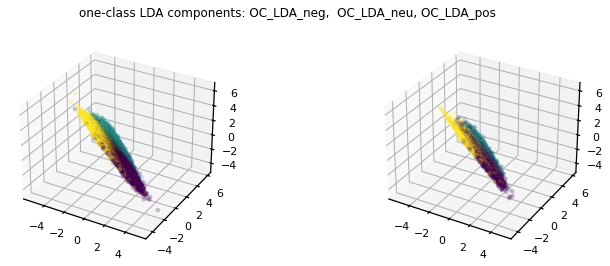

reading FRILL embeddings...
training one-class LDA on neg
training one-class LDA on neu
training one-class LDA on pos
saving train data...
saving test data...


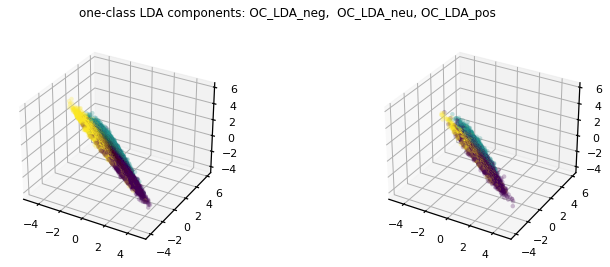

reading FRILL embeddings...
training one-class LDA on neg
training one-class LDA on neu
training one-class LDA on pos
saving train data...
saving test data...


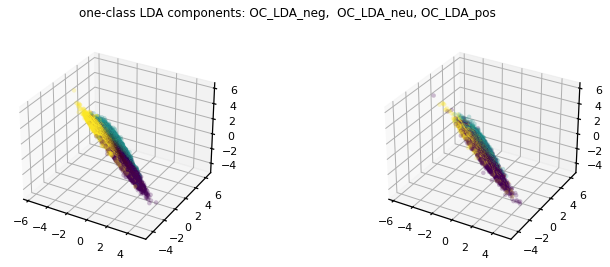

reading FRILL embeddings...
training one-class LDA on neg
training one-class LDA on neu
training one-class LDA on pos
saving train data...
saving test data...


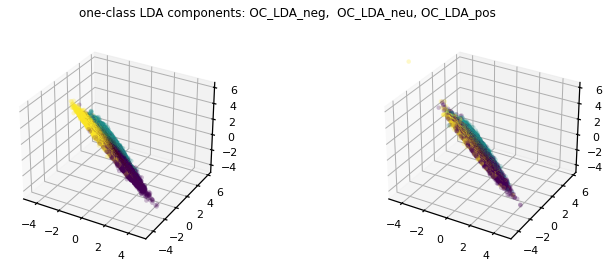

reading FRILL embeddings...
training one-class LDA on neg
training one-class LDA on neu
training one-class LDA on pos
saving train data...
saving test data...


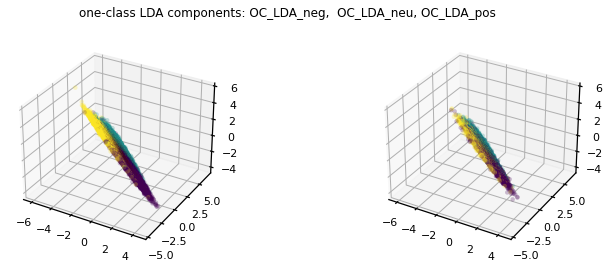

time: 12min 11s


In [10]:
already_completed = []
for fold_num in (0, 1, 2, 3, 4):
    if fold_num in already_completed:
        continue

    # read
    print("reading FRILL embeddings...")
    X_train, y_train = read_FRILL("train", fold_num)
    X_test, y_test = read_FRILL("test", fold_num)
    train_valence_cols, test_valence_cols = {}, {}

    # extract
    for valence in VALENCES:
        feature = f"OC_LDA_{valence}"
        print(f"training one-class LDA on {valence}")
        lda = LinearDiscriminantAnalysis().fit(X_train, RECODER[valence](y_train))
        train_valence_cols[feature] = np.squeeze(lda.transform(X_train))
        test_valence_cols[feature] = np.squeeze(lda.transform(X_test))
        del feature
        del lda
        _ = gc_collect()
    assert not X_train.isnull().values.any()
    assert not X_test.isnull().values.any()
    del X_train
    del X_test
    _ = gc_collect()

    # save
    print("saving train data...")
    pd.DataFrame(train_valence_cols).reset_index(drop=True).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_train_OC_LDA.feather"
    )
    del train_valence_cols
    _ = gc_collect()
    print("saving test data...")
    pd.DataFrame(test_valence_cols).reset_index(drop=True).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_test_OC_LDA.feather"
    )
    del test_valence_cols
    _ = gc_collect()

    # visualize
    read_feather = lambda filename: pd.read_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}/{filename}.feather"
    )
    plot3d(
        "OC_LDA_neg",
        "OC_LDA_neu",
        "OC_LDA_pos",
        read_feather("X_train_OC_LDA"),
        y_train,
        read_feather("X_test_OC_LDA"),
        y_test,
        suptitle="one-class LDA components",
    )
    del y_train
    del y_test
    _ = gc_collect()

del already_completed
_ = gc_collect()

## Spherical coordinates from optionally scaled data

reading non-FRILL data...
extracting polar/spherical coordinates...
concatenating new coordinates...
extracting LDA components of polar/spherical data...
extracting one-class LDA components of polar/spherical data...
training one-class LDA on polar/spherical coordinates for neg
training one-class LDA on polar/spherical coordinates for neu
training one-class LDA on polar/spherical coordinates for pos
aggregating new features...
saving sphericals...


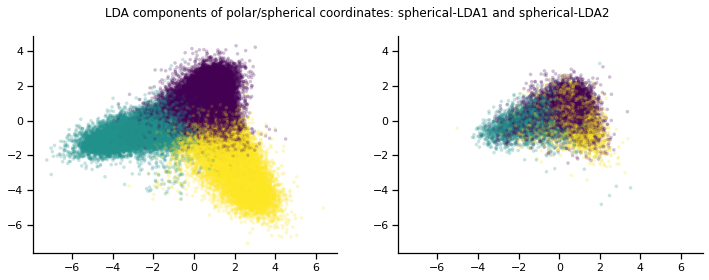

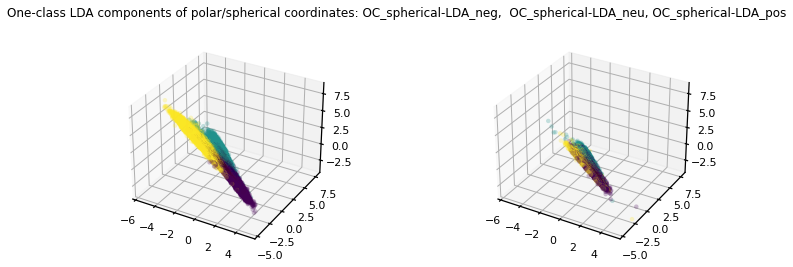

reading non-FRILL data...
extracting polar/spherical coordinates...
concatenating new coordinates...
extracting LDA components of polar/spherical data...
extracting one-class LDA components of polar/spherical data...
training one-class LDA on polar/spherical coordinates for neg
training one-class LDA on polar/spherical coordinates for neu
training one-class LDA on polar/spherical coordinates for pos
aggregating new features...
saving sphericals...


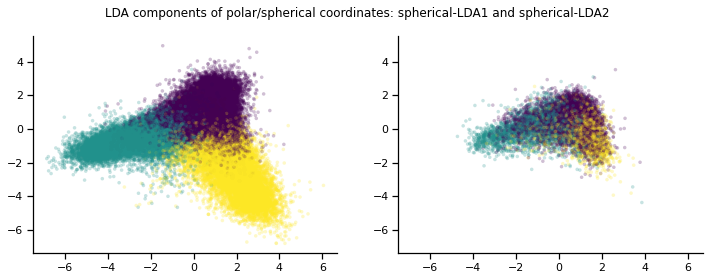

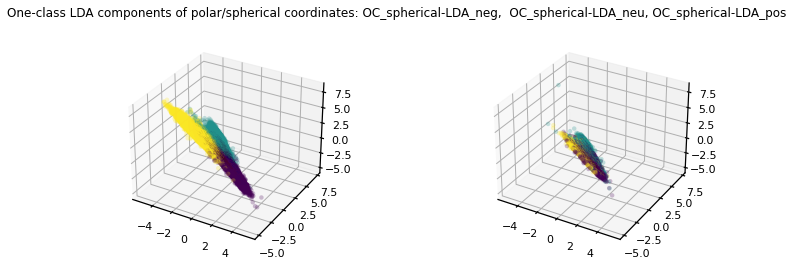

reading non-FRILL data...
extracting polar/spherical coordinates...
concatenating new coordinates...
extracting LDA components of polar/spherical data...
extracting one-class LDA components of polar/spherical data...
training one-class LDA on polar/spherical coordinates for neg
training one-class LDA on polar/spherical coordinates for neu
training one-class LDA on polar/spherical coordinates for pos
aggregating new features...
saving sphericals...


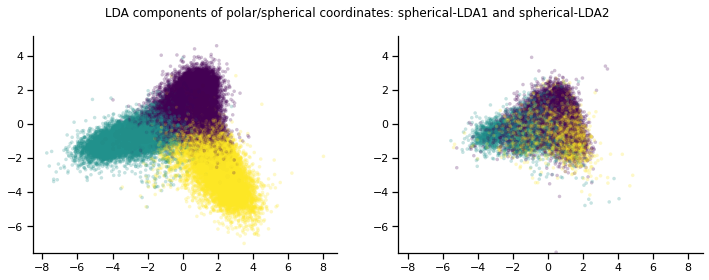

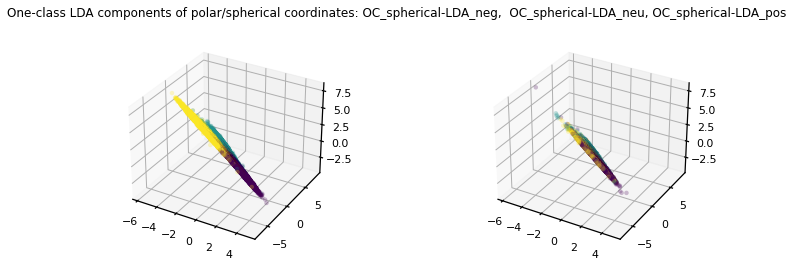

reading non-FRILL data...
extracting polar/spherical coordinates...
concatenating new coordinates...
extracting LDA components of polar/spherical data...
extracting one-class LDA components of polar/spherical data...
training one-class LDA on polar/spherical coordinates for neg
training one-class LDA on polar/spherical coordinates for neu
training one-class LDA on polar/spherical coordinates for pos
aggregating new features...
saving sphericals...


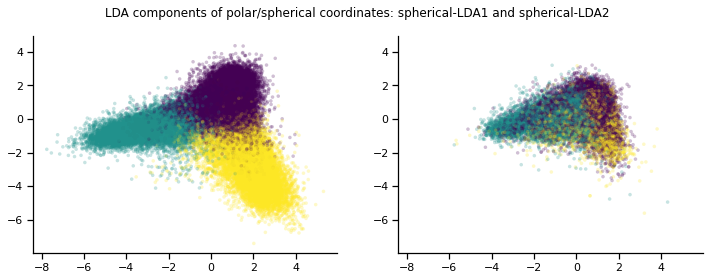

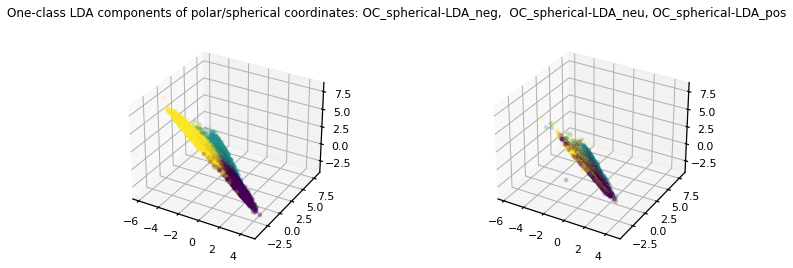

reading non-FRILL data...
extracting polar/spherical coordinates...
concatenating new coordinates...
extracting LDA components of polar/spherical data...
extracting one-class LDA components of polar/spherical data...
training one-class LDA on polar/spherical coordinates for neg
training one-class LDA on polar/spherical coordinates for neu
training one-class LDA on polar/spherical coordinates for pos
aggregating new features...
saving sphericals...


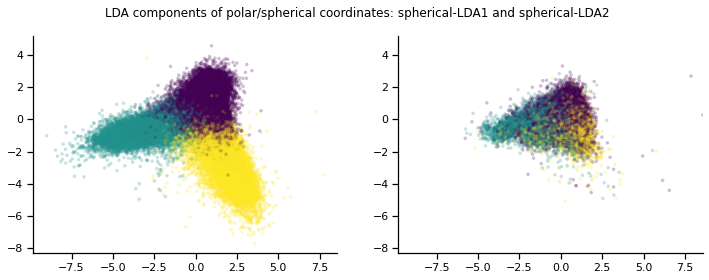

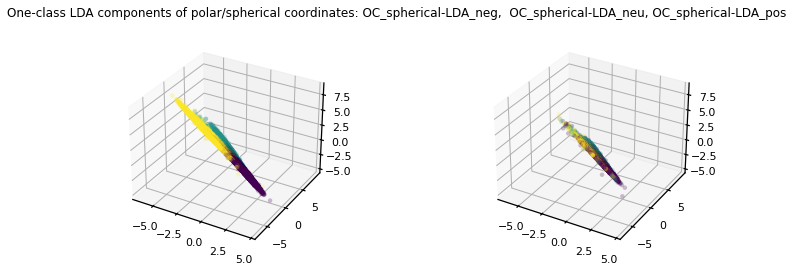

time: 3min 12s


In [11]:
already_completed = []
for fold_num in (0, 1, 2, 3, 4):
    if fold_num in already_completed:
        continue

    # read
    print("reading non-FRILL data...")
    X_train, y_train = read_data("train", fold_num=fold_num)
    X_test, y_test = read_data("test", fold_num=fold_num)
    train_idx, test_idx = X_train.index, X_test.index
    train_columns, test_columns = X_train.columns, X_test.columns

    # extract
    print("extracting polar/spherical coordinates...")
    train_coordinates: List[Dict[str, pd.DataFrame]] = []
    test_coordinates: List[Dict[str, pd.DataFrame]] = []
    # scale
    for scaler_key in SCALERS:
        if scaler_key:
            scaler = SCALERS[scaler_key]().fit(X_train)
            X_train_ = pd.DataFrame(scaler.transform(X_train))
            X_test_ = pd.DataFrame(scaler.transform(X_test))
            X_train_.columns, X_test_.columns = train_columns, test_columns
            del scaler
            _ = gc_collect()
        else:
            X_train_, X_test_ = X_train, X_test
        X_train_ = pd.DataFrame(extract_spherical_features(X_train_, scaler=scaler_key))
        X_test_ = pd.DataFrame(extract_spherical_features(X_test_, scaler=scaler_key))
        train_coordinates.append(X_train_)
        test_coordinates.append(X_test_)
        del X_train_
        del X_test_
        _ = gc_collect()

    del X_train
    del X_test
    del train_columns
    del test_columns
    _ = gc_collect()

    # aggregate
    print("concatenating new coordinates...")
    train_df = pd.concat(train_coordinates, axis="columns")
    train_df.index = train_idx
    test_df = pd.concat(test_coordinates, axis="columns")
    test_df.index = test_idx
    del train_coordinates
    del test_coordinates
    _ = gc_collect()

    # LDA of sphericals
    print("extracting LDA components of polar/spherical data...")
    train_cols, test_cols = {}, {}
    lda = LinearDiscriminantAnalysis().fit(train_df, y_train)
    components = lda.transform(train_df)
    train_cols["spherical-LDA1"], train_cols["spherical-LDA2"] = (
        components[:, 0],
        components[:, 1],
    )
    components = lda.transform(test_df)
    test_cols["spherical-LDA1"], test_cols["spherical-LDA2"] = (
        components[:, 0],
        components[:, 1],
    )
    del components
    del lda
    _ = gc_collect()

    # one-class LDAs of sphericals
    print("extracting one-class LDA components of polar/spherical data...")
    for valence in VALENCES:
        feature = f"OC_spherical-LDA_{valence}"
        print(f"training one-class LDA on polar/spherical coordinates for {valence}")
        lda = LinearDiscriminantAnalysis().fit(train_df, RECODER[valence](y_train))
        train_cols[feature] = np.squeeze(lda.transform(train_df))
        test_cols[feature] = np.squeeze(lda.transform(test_df))
        del feature
        del lda
        _ = gc_collect()

    # concatenate features
    print("aggregating new features...")
    train_df = pd.concat([train_df, pd.DataFrame(train_cols)], axis="columns")
    test_df = pd.concat([test_df, pd.DataFrame(test_cols)], axis="columns")
    del train_cols
    del test_cols
    _ = gc_collect()

    # save sphericals
    print("saving sphericals...")
    prefix = f"{DATA_OUT_FOLDER}/cv_{fold_num}"
    # non-default index not supported with .feather
    train_df.reset_index(drop=True).to_feather(f"{prefix}/X_train_sphericals.feather")
    del train_df
    _ = gc_collect()
    test_df.reset_index(drop=True).to_feather(f"{prefix}/X_test_sphericals.feather")
    del test_df
    _ = gc_collect()

    # visualize LDA features
    read_feather = lambda filename: pd.read_feather(f"{prefix}/{filename}.feather")
    X_train = read_feather("X_train_sphericals")
    X_test = read_feather("X_test_sphericals")
    del prefix
    del read_feather
    _ = gc_collect()
    plot2d(
        "spherical-LDA1",
        "spherical-LDA2",
        X_train,
        y_train,
        X_test,
        y_test,
        suptitle="LDA components of polar/spherical coordinates",
    )
    plot3d(
        "OC_spherical-LDA_neg",
        "OC_spherical-LDA_neu",
        "OC_spherical-LDA_pos",
        X_train,
        y_train,
        X_test,
        y_test,
        suptitle="One-class LDA components of polar/spherical coordinates",
    )
    del X_train
    del X_test
    del y_train
    del y_test
    _ = gc_collect()

# Concatenate features

In [20]:
for fold_num in (0, 1, 2, 3, 4):
    prefix = f"{DATA_OUT_FOLDER}/cv_{fold_num}"
    _ = pd.concat(
        [
            read_data("train", fold_num)[0].reset_index(drop=True),
            pd.read_feather(f"{prefix}/X_train_sphericals.feather"),
        ],
        axis="columns",
    )
    assert not _.isnull().values.any()
    _.to_feather(f"{prefix}/X_train_nonFRILL.feather")
    _ = pd.concat(
        [
            read_data("test", fold_num)[0],
            pd.read_feather(f"{prefix}/X_test_sphericals.feather"),
        ],
        axis="columns",
    ).reset_index(drop=True)
    assert not _.isnull().values.any()
    _.to_feather(f"{prefix}/X_test_nonFRILL.feather")
    _ = pd.read_feather(f"{prefix}/X_train_nonFRILL.feather")
    assert not _.isnull().values.any()
    _.head()
    _.info()
    _ = pd.read_feather(f"{prefix}/X_test_nonFRILL.feather")
    assert not _.isnull().values.any()
    _.head()
    _.info()
    del _
    _ = gc_collect()

,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-0.466160,-0.417321,-1.019365,-0.992906,-1.023976,-1.003768,-1.047069,-1.028301,-1.005821,-1.062403,...,2.202875,-2.356059,0.537957,1.750568,-0.449538,0.899253,2.199645,2.372473,-1.503731,-1.390829
1,-1.386042,0.498734,-1.011286,-1.067941,-1.065737,-0.996379,-1.073280,-1.041404,-1.007037,-1.162475,...,0.947035,1.181595,1.501380,0.911079,-1.203621,1.238129,1.780659,2.113266,-1.704548,-0.857519
2,-0.850266,-0.874606,-1.033421,-1.023847,-0.983519,-1.013320,-1.029479,-0.997826,-1.010492,-1.024317,...,2.268733,-2.330641,1.187907,1.883833,-0.544737,1.175819,2.386456,2.649576,-1.822631,-1.403640
3,-1.227870,-0.205705,-1.107171,-1.202716,-1.009307,-1.065716,-1.106178,-1.028698,-1.043809,-1.154562,...,2.284825,-2.486242,1.268721,1.293480,-0.895919,0.841941,1.273917,1.495312,-1.177600,-0.636552
4,-1.675318,-0.576157,-1.025916,-1.427719,-1.007936,-1.003349,-1.859797,-0.982235,-1.007320,-1.791692,...,1.026127,0.833881,1.941015,1.471209,-0.865289,1.069290,2.341960,2.568226,-1.707858,-1.421975


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73258 entries, 0 to 73257
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 297.9 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-2.328962,-0.920432,-1.104291,-1.669893,-1.020840,-1.007294,-2.231030,-1.065473,-1.011342,-2.524692,...,0.988265,0.801574,2.947630,1.527213,-0.878831,0.619626,0.939215,1.102027,-0.867150,-0.469886
1,-1.408425,-2.435387,-0.984571,-1.208943,-1.406233,-1.024385,-1.288348,-1.541694,-1.012270,-1.536142,...,0.972008,0.761596,3.109045,2.126389,-0.476085,1.598255,2.001778,2.453636,-2.113317,-0.855438
2,-1.597667,-0.907780,-1.113776,-2.102123,-0.989630,-1.014420,-1.763541,-1.017346,-1.020159,-1.641919,...,1.024473,0.803643,1.993744,1.631780,-0.773096,0.635583,2.122818,2.201885,-1.229374,-1.464437
3,-1.669079,-0.299666,-1.004773,-1.280347,-0.969815,-1.003065,-1.542614,-0.997191,-0.998825,-1.574748,...,1.031542,0.862528,1.852236,1.343035,-0.937587,0.437487,1.345423,1.408624,-0.812270,-0.909915
4,-1.857996,-1.267038,-0.977665,-1.516206,-0.977578,-0.987523,-1.801374,-0.990697,-1.005193,-1.829495,...,0.995693,0.790485,2.525066,1.709396,-0.751710,0.661057,1.880181,1.987264,-1.182569,-1.245436


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13494 entries, 0 to 13493
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 54.9 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-0.617625,-0.408766,-1.006562,-1.018480,-1.009058,-0.988307,-1.012973,-1.005942,-0.994436,-1.009113,...,2.211006,-2.360830,0.659549,1.616251,-0.577632,0.893850,2.319427,2.480526,-1.498286,-1.528048
1,-1.212777,0.524709,-1.037013,-1.380705,-1.025475,-1.043123,-1.284829,-1.025435,-1.052301,-1.240019,...,2.103104,-2.597667,1.326817,0.832688,-1.247280,1.479397,1.019781,1.512125,-1.702106,-0.115487
2,-0.939254,-0.896575,-1.011238,-1.021217,-1.089894,-1.005300,-0.992877,-1.015386,-1.003326,-1.006795,...,2.339398,-2.303315,1.281863,1.853232,-0.583039,0.979045,2.786830,2.943543,-1.709022,-1.884588
3,-1.809333,0.592327,-0.980853,-1.250086,-1.070592,-0.976756,-1.411974,-1.038607,-0.992199,-1.643049,...,0.952793,0.850716,2.021995,1.000875,-1.224912,0.534072,1.356062,1.454706,-0.887005,-0.887501
4,-1.511705,-0.594454,-1.018828,-1.062533,-1.027649,-1.000333,-1.228636,-1.007247,-0.989416,-1.318825,...,1.082402,0.851512,1.740627,1.503119,-0.841403,1.111570,2.570335,2.795809,-1.776582,-1.631368


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75228 entries, 0 to 75227
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 305.9 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-1.520533,-0.636652,-1.030841,-1.153554,-1.011578,-1.037213,-1.212494,-1.007976,-1.016745,-1.355669,...,1.072216,0.838252,1.769559,1.522356,-0.831454,0.799769,0.651826,0.909935,-0.947891,-0.148499
1,-1.095483,0.948637,-0.951646,-1.257218,-1.000091,-0.977404,-1.257115,-1.034932,-0.978585,-1.316795,...,0.314953,1.770938,1.383864,0.609279,-1.554773,0.876675,-0.966973,-0.549413,-0.575223,1.276832
2,-0.899663,0.123195,-0.993563,-1.000318,-1.055369,-0.983787,-1.034898,-1.037422,-0.992748,-1.023339,...,2.201094,-2.398415,0.881427,0.964475,-1.011926,1.203724,1.128593,1.505251,-1.467357,-0.349818
3,-0.234388,-0.762712,-1.095342,-1.061066,-1.041782,-1.050401,-1.009231,-1.041465,-1.016918,-1.010457,...,2.184115,-2.324979,0.753066,2.292449,-0.106022,0.118045,0.913575,0.886223,-0.365388,-0.721711
4,-0.163137,-0.590403,-1.026237,-1.008439,-0.993165,-1.011608,-1.009503,-1.000732,-1.006686,-1.024763,...,2.183110,-2.335212,0.556355,2.281560,-0.009666,0.111245,1.118932,1.072496,-0.415530,-0.901010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 46.9 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-0.571014,-0.519213,-0.977475,-1.003723,-1.015086,-0.999627,-1.004898,-1.014138,-1.007378,-0.988596,...,2.210135,-2.354498,0.667006,1.738151,-0.508367,0.774692,2.563985,2.669751,-1.545182,-1.738804
1,-0.592194,0.142372,-0.984805,-1.089487,-1.109908,-0.989513,-1.001805,-1.091981,-1.005888,-1.016432,...,2.191476,-2.377611,0.558676,0.679907,-1.043301,0.876439,2.252930,2.414041,-1.543210,-1.422689
2,-0.415522,0.176439,-1.022282,-1.006410,-1.007087,-0.996924,-1.063872,-1.022211,-0.989551,-1.048827,...,2.183662,-2.370707,0.437704,0.406205,-1.112616,1.246666,2.242550,2.533252,-1.890765,-1.215034
3,-1.698219,-0.010754,-1.019216,-1.228259,-1.054633,-1.012620,-1.568730,-1.033979,-0.985554,-1.585513,...,1.023188,0.894350,1.836366,1.193776,-1.065944,0.677914,1.280647,1.434811,-1.047518,-0.712143
4,-1.411570,-0.484127,-1.044394,-1.168604,-1.067783,-1.009061,-1.183790,-1.021987,-1.010598,-1.313800,...,1.312038,1.015480,1.559865,1.427424,-0.875111,0.913819,2.486364,2.645553,-1.652471,-1.598808


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67433 entries, 0 to 67432
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 274.2 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-1.895345,0.630435,-0.991207,-1.035860,-0.996020,-0.982375,-1.600962,-1.116419,-0.986489,-1.743013,...,0.949737,0.848050,2.095872,0.994563,-1.278951,0.620134,0.341674,0.535788,-0.695743,0.046029
1,0.042633,-0.810630,-1.048599,-0.971885,-1.004627,-1.039921,-0.994040,-1.028233,-1.055501,-0.997579,...,2.161674,-2.320386,0.781191,2.483435,0.301432,0.902427,0.692463,0.962425,-1.074216,-0.097130
2,-0.258546,-0.973134,-1.076548,-1.052675,-1.015000,-1.079089,-1.027630,-0.991892,-1.053237,-1.028272,...,2.179578,-2.296941,0.963189,2.307257,-0.120037,1.190876,1.097356,1.441889,-1.475637,-0.282461
3,-0.204411,-0.110600,-1.090783,-1.051656,-0.972756,-1.056738,-1.039357,-1.008063,-1.010120,-1.021157,...,2.193301,-2.360548,0.176271,0.970091,-0.039418,0.905718,1.233592,1.470097,-1.248497,-0.550191
4,-0.127978,-1.001190,-0.985179,-0.990700,-0.965499,-0.983862,-1.008552,-0.992959,-0.991839,-1.020111,...,2.162682,-2.292242,0.984444,2.406463,0.016221,0.559745,1.170527,1.290572,-0.900699,-0.683080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19319 entries, 0 to 19318
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 78.6 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-0.241050,0.229912,-0.998713,-1.090139,-1.022431,-0.979872,-1.023755,-1.024386,-0.988644,-1.013505,...,2.177597,-2.359048,0.395470,0.104997,-1.582575,1.462757,1.804233,2.249824,-1.846029,-0.888535
1,-0.371592,-0.859147,-0.963177,-1.030491,-1.032741,-0.994994,-1.046094,-1.070376,-0.993942,-1.051198,...,2.195691,-2.320639,0.879546,2.246544,-0.215274,1.265390,2.606196,2.891836,-1.843361,-1.686169
2,-1.060156,-0.269418,-1.016646,-1.035943,-1.025748,-0.984045,-1.014377,-1.044047,-0.994372,-1.033617,...,2.244036,-2.409006,1.048101,1.358837,-0.840125,1.357031,2.259660,2.617110,-1.850685,-1.338491
3,-0.533438,-0.950384,-0.973713,-1.000987,-1.023984,-0.981948,-1.029684,-1.012528,-0.984103,-1.054117,...,2.211043,-2.308320,1.034149,2.169790,-0.330822,1.149979,2.397353,2.654191,-1.682039,-1.557701
4,-0.614634,-3.670842,-1.154376,-1.664932,-3.863952,-1.171008,-2.156044,-3.555261,-1.199233,-2.378352,...,0.950318,0.743561,4.133687,2.430401,-0.137440,1.403288,1.924514,2.333528,-1.816610,-1.022396


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60869 entries, 0 to 60868
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 247.5 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,0.348099,-0.297616,-1.134703,-1.148085,-1.167386,-1.036372,-1.023746,-1.060284,-1.041281,-1.016575,...,2.176077,-2.363340,0.439234,2.223941,1.568167,0.874851,1.149668,1.409434,-1.120710,-0.593372
1,-1.033945,-0.732897,-0.999807,-1.013340,-0.936903,-1.023066,-1.031023,-0.986597,-1.006029,-1.056706,...,2.320146,-2.383724,1.221683,1.733974,-0.660492,1.054019,1.351819,1.667955,-1.342377,-0.685669
2,-1.777782,-2.715783,-1.071065,-1.856749,-1.877046,-1.032864,-1.980596,-1.822689,-1.034526,-2.185846,...,0.976036,0.761668,3.685020,2.107386,-0.525216,0.815746,1.762430,1.938725,-1.207745,-1.159241
3,-0.239618,0.194751,-1.078774,-1.057269,-1.006816,-0.988276,-0.993384,-1.022595,-0.979101,-0.999038,...,2.180903,-2.362556,0.364529,0.122048,-1.157504,1.341204,0.649556,1.154065,-1.455787,0.067095
4,-1.535992,1.016611,-0.995417,-1.189296,-1.008825,-1.026954,-1.252313,-0.972833,-1.024797,-1.381042,...,0.900767,0.834690,1.787857,0.798779,-1.415155,1.419254,-0.020921,0.580571,-1.373556,0.692603


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25883 entries, 0 to 25882
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 105.3 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-0.469658,0.304279,-0.979703,-1.111231,-1.035459,-0.976611,-1.011910,-1.018996,-0.971203,-1.003740,...,2.178473,-2.370931,0.543421,0.321354,-1.543238,0.981092,2.703163,2.865088,-1.662458,-1.894468
1,-2.361910,0.091601,-1.079434,-1.939101,-0.983279,-1.054094,-2.137924,-0.996033,-1.062246,-2.138423,...,0.979809,0.836667,2.696971,1.209564,-1.131468,0.792688,1.015913,1.242056,-1.033109,-0.509074
2,-0.793451,-2.763101,-0.993484,-1.313967,-1.419384,-1.003647,-1.485903,-1.565215,-0.998488,-1.579568,...,0.952266,0.729632,3.238645,2.296324,-0.305270,0.545907,2.143530,2.181450,-1.094761,-1.613355
3,-0.135026,0.954113,-1.067921,-1.014066,-1.003915,-1.018536,-1.010382,-0.994780,-0.980630,-1.032458,...,2.135372,-2.297203,1.018502,0.573920,2.902311,0.793210,1.758371,1.924136,-1.230713,-1.158127
4,-1.807235,1.346629,-1.009213,-1.559248,-0.985054,-1.036228,-1.713544,-1.000210,-1.013829,-1.952224,...,0.919309,0.813840,2.103232,0.779306,-1.586723,1.460321,-0.082292,0.493742,-1.384571,0.770870


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70220 entries, 0 to 70219
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 285.5 MB


,LDA1,LDA2,LDA-LOF_neg_10,LDA-LOF_neu_10,LDA-LOF_pos_10,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-LOF_neg_30,LDA-LOF_neu_30,...,theta_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,phi_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos,rho_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,theta_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,phi_QT-norm_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos,spherical-LDA1,spherical-LDA2,OC_spherical-LDA_neg,OC_spherical-LDA_neu,OC_spherical-LDA_pos
0,-1.276810,1.460137,-1.067047,-1.320988,-1.089884,-1.043236,-1.386199,-0.991028,-1.050901,-1.386793,...,0.864714,0.784730,1.704564,0.572167,-1.930626,1.562580,-0.034810,0.577218,-1.495655,0.778276
1,-0.911005,-0.273262,-1.010698,-1.008303,-1.029617,-0.990855,-0.996189,-1.016830,-0.991815,-1.019760,...,2.226951,-2.397161,0.886256,1.308912,-0.830986,0.951000,1.342589,1.603797,-1.272296,-0.719003
2,-1.678609,-0.633235,-1.105320,-1.107548,-0.991060,-1.070755,-1.356432,-1.007192,-1.048978,-1.421765,...,1.041459,0.846937,1.973873,1.458079,-0.890772,0.994871,0.584300,0.924485,-1.113256,-0.034852
3,-0.405103,-0.283004,-1.036101,-0.986116,-1.027349,-1.066026,-0.992640,-0.997128,-1.025008,-1.005537,...,2.201271,-2.360230,0.376725,1.464443,-0.437735,0.284576,0.864612,0.905008,-0.503585,-0.619935
4,-0.212779,-4.041316,-1.250089,-2.225743,-2.843365,-1.329687,-2.326816,-3.015329,-1.506973,-2.596381,...,0.933931,0.723753,4.396009,2.413083,-0.091539,0.755886,0.373771,0.637970,-0.827204,0.034916


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16532 entries, 0 to 16531
Columns: 533 entries, LDA1 to OC_spherical-LDA_pos
dtypes: float64(533)
memory usage: 67.2 MB
time: 12.1 s


In [13]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 943.4242980480194 s
time: 126 ms


[^top](#Contents)